# I] Import functions and options

In [1]:
import pandas, numpy, math, seaborn
import scipy, scipy.stats
import matplotlib, matplotlib.pyplot as plt
# this is a trick to make figures look nicer
matplotlib.rcParams.update({'font.size':20, 'font.family':'FreeSans', 'xtick.labelsize':20, 'ytick.labelsize':10, 'figure.figsize':(12, 8)})
matplotlib.rcParams['svg.fonttype'] = 'none'
from matplotlib_venn import venn2

In [2]:
input_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7//0 in_silico/Python/1)data_input/'

In [3]:
output_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7/0 in_silico/Python/3)output/'

# II] Data download

In [4]:
%%time
# DL data gene expression for Normal Tissue and Primary Tumors
path = output_file_directory + "ATG7/TCGA_GTEX/all_tissues/dataframes_for_input/"
ensembl_normal_atg7_proteinGE = pandas.read_csv(path+"ensembl_normal_atg7_proteinGE.tsv", sep = "\t")
ensembl_primary_atg7_proteinGE = pandas.read_csv(path+"ensembl_primary_atg7_proteinGE.tsv", sep = "\t")

print(ensembl_normal_atg7_proteinGE.shape)
print(ensembl_primary_atg7_proteinGE.shape)
ensembl_normal_atg7_proteinGE.head(2)

(7429, 19387)
(9185, 19387)
Wall time: 3min 33s


,Sample_Type,Primary_Site,ATG7,ATG7_1,ATG7_2,ENSG00000198888,ENSG00000198763,ENSG00000198804,ENSG00000198712,ENSG00000228253,...,ENSG00000160678,ENSG00000160679,ENSG00000143553,ENSG00000214193,ENSG00000196182,ENSG00000181817,ENSG00000116885,ENSG00000116898,ENSG00000119535,ENSG00000142694
0,Normal Tissue,Muscle,5.042,3.860,2.390,14.0639,13.9595,13.8503,14.4453,15.0971,...,2.7868,5.6494,5.0193,2.694,4.5274,5.0998,2.3423,6.0790,6.4861,4.9700
1,Normal Tissue,Muscle,4.252,2.322,1.956,13.9265,13.5455,15.2642,14.3855,15.1867,...,9.3501,6.1104,6.0570,1.177,6.8792,6.4325,2.1013,6.7035,1.1706,1.3167


In [5]:
%%time
#download the protein coding list. will be useful with correlation results.
path = input_file_directory + "protein_coding_list.txt"
protein_coding_list= pandas.read_csv(path, sep = "\t")
print(protein_coding_list.shape)
protein_coding_list.head()

(22796, 4)
Wall time: 35.9 ms


,ensembl_gene_id,hgnc_symbol,entrezgene_id,transcript_biotype
1,ENSG00000198888,MT-ND1,4535.0,protein_coding
2,ENSG00000198763,MT-ND2,4536.0,protein_coding
3,ENSG00000198804,MT-CO1,4512.0,protein_coding
4,ENSG00000198712,MT-CO2,4513.0,protein_coding
5,ENSG00000228253,MT-ATP8,4509.0,protein_coding


# III] Expression correlation between ATG7 and all protein coding 

In [8]:
%%time
# Spearman Correlation, all genes WITHOUT cutoff
all_tissue_used = [[ensembl_normal_atg7_proteinGE,'Normal_Tissues'], 
                   [ensembl_primary_atg7_proteinGE,'Primary_Tumors']]

isoforms = ['ATG7_1', 'ATG7_2']

all_positiv_corr_spearman = []
all_negativ_corr_spearman = []

for tissue in all_tissue_used:
  print(tissue[1], tissue[0].shape)

  #create a new row with max() for each gene and transpose
  tissue[0].loc['max()'] = tissue[0].max()
  tissue[0] = tissue[0].T

  #select all row where max() > 2.3 (= 5 tpm)
  nb_before = tissue[0]['max()'].count()
  tissue[0] = tissue[0].drop(tissue[0].index[0:2])
  tissue[0] = tissue[0][tissue[0]['max()'] > 2.3]
  nb_after = tissue[0]['max()'].count()
  print("number of genes removed:", nb_before-nb_after)
  print('the minimum of TPM is', tissue[0]['max()'].min())
  
  #delete the column max() and tranpose back
  tissue[0] =  tissue[0].drop('max()', axis = 1) 
  tissue[0] = tissue[0].T
  print('nombre genes after removing < 5tpm', tissue[0].shape)

  for isoform in isoforms:

    genepos = []
    geneneg = []
    rvaluepos = []
    rvalueneg = []
    pvaluepos = []
    pvalueneg = []

    print(isoform)
    x = tissue[0][isoform].to_list()
    genes = tissue[0].columns[3:]

    for gene in genes:
      y = tissue[0][gene].to_list()
      r_value, p_value = scipy.stats.spearmanr(x, y)

      if r_value > 0:
        genepos.append(gene)
        rvaluepos.append(r_value)
        pvaluepos.append(p_value)
        
      elif r_value < 0:
        geneneg.append(gene)
        rvalueneg.append(r_value)
        pvalueneg.append(p_value)

    #create a dictionnary
    d = dict(ensembl_gene_id= genepos, r_value=rvaluepos,  p_value=pvaluepos)
    d2 = dict(ensembl_gene_id= geneneg, r_value=rvalueneg,  p_value=pvalueneg)

    #Convert to dataframe
    df_positiv_corr = pandas.DataFrame.from_dict(d, orient='index')
    df_negativ_corr = pandas.DataFrame.from_dict(data=d2, orient='index')

    #Transpose to have a better table
    df_positiv_corr = df_positiv_corr.transpose()
    df_negativ_corr = df_negativ_corr.transpose()

    #name
    positiv_corr = 'pos_spearman_corr_'+tissue[1]+'_'+isoform
    negativ_corr = 'neg_spearman_corr_'+tissue[1]+'_'+isoform

    print(positiv_corr, df_positiv_corr.shape)
    print(negativ_corr, df_negativ_corr.shape)

    #scending orde, save to excel
    df_positiv_corr['info'] = tissue[1]+'_'+isoform
    df_positiv_corr = protein_coding_list.merge(df_positiv_corr)
    df_positiv_corr = df_positiv_corr.drop(['entrezgene_id', 'transcript_biotype'], axis = 1)
    df_positiv_corr = df_positiv_corr.sort_values(['r_value'], ascending = False)
    
    #save positive
    path = 'ATG7/table_correlation_enrichr/all_tissue_ATG7/corr_all/'
#     df_positiv_corr.to_excel(output_file_directory+path+positiv_corr+'.xlsx', index=False)
    
    df_negativ_corr['info'] = tissue[1]+'_'+isoform
    df_negativ_corr = protein_coding_list.merge(df_negativ_corr)
    df_negativ_corr = df_negativ_corr.drop(['entrezgene_id', 'transcript_biotype'], axis = 1)
    df_negativ_corr = df_negativ_corr.sort_values(['r_value'], ascending = False)
    
    #save negative
#     df_negativ_corr.to_excel(output_file_directory+path+negativ_corr+'.xlsx', index=False)

    all_positiv_corr_spearman.append(df_positiv_corr)
    all_negativ_corr_spearman.append(df_negativ_corr)
  print()

Normal_Tissues (7429, 19387)
number of genes removed: 787
the minimum of TPM is 2.321928094887362
nombre genes after removing < 5tpm (7429, 18599)
ATG7_1
pos_spearman_corr_Normal_Tissues_ATG7_1 (17537, 3)
neg_spearman_corr_Normal_Tissues_ATG7_1 (1059, 3)
ATG7_2
pos_spearman_corr_Normal_Tissues_ATG7_2 (10850, 3)
neg_spearman_corr_Normal_Tissues_ATG7_2 (7746, 3)

Primary_Tumors (9185, 19387)
number of genes removed: 680
the minimum of TPM is 2.321928094887362
nombre genes after removing < 5tpm (9185, 18707)
ATG7_1
pos_spearman_corr_Primary_Tumors_ATG7_1 (12711, 3)
neg_spearman_corr_Primary_Tumors_ATG7_1 (5993, 3)
ATG7_2
pos_spearman_corr_Primary_Tumors_ATG7_2 (13382, 3)
neg_spearman_corr_Primary_Tumors_ATG7_2 (5322, 3)

Wall time: 5min 37s


## 1) Distribution of all rvalue to select cutoff

In [9]:
%%time
#Merge Negative and Positive data
data =  [
         [all_negativ_corr_spearman[0], all_positiv_corr_spearman[0], 'Normal Tissue, ATG7(1)'], 
         [all_negativ_corr_spearman[1], all_positiv_corr_spearman[1], 'Normal Tissue, ATG7(2)'],
         [all_negativ_corr_spearman[2], all_positiv_corr_spearman[2], 'Primary Tumor, ATG7(1)'], 
         [all_negativ_corr_spearman[3], all_positiv_corr_spearman[3], 'Primary Tumor, ATG7(2)']
         ]

all_corr_negpos_merged = []
for dfs in data:
  print(dfs[2])
  print('shape positiv', dfs[0].shape)
  print('shape negativ', dfs[1].shape)

  df_merged = pandas.concat([dfs[0], dfs[1]], axis=0)
  df_merged = df_merged.reset_index(drop = True)
  print('shape after merge', df_merged.shape)
  all_corr_negpos_merged.append(df_merged)
  print()

all_corr_negpos_merged[1]

Normal Tissue, ATG7(1)
shape positiv (1065, 5)
shape negativ (17666, 5)
shape after merge (18731, 5)

Normal Tissue, ATG7(2)
shape positiv (7803, 5)
shape negativ (10928, 5)
shape after merge (18731, 5)

Primary Tumor, ATG7(1)
shape positiv (6043, 5)
shape negativ (12795, 5)
shape after merge (18838, 5)

Primary Tumor, ATG7(2)
shape positiv (5357, 5)
shape negativ (13481, 5)
shape after merge (18838, 5)

Wall time: 28 ms


,ensembl_gene_id,hgnc_symbol,r_value,p_value,info
0,ENSG00000150433,TMEM218,-2.35845e-05,0.998378,Normal_Tissues_ATG7_2
1,ENSG00000119888,EPCAM,-2.68003e-05,0.998157,Normal_Tissues_ATG7_2
2,ENSG00000164182,NDUFAF2,-4.25323e-05,0.997076,Normal_Tissues_ATG7_2
3,ENSG00000083544,TDRD3,-5.2515e-05,0.996389,Normal_Tissues_ATG7_2
4,ENSG00000070526,ST6GALNAC1,-6.55079e-05,0.995496,Normal_Tissues_ATG7_2
...,...,...,...,...,...
18726,ENSG00000101104,PABPC1L,8.44545e-05,0.994193,Normal_Tissues_ATG7_2
18727,ENSG00000132549,VPS13B,3.54402e-05,0.997563,Normal_Tissues_ATG7_2
18728,ENSG00000183579,ZNRF3,3.50075e-05,0.997593,Normal_Tissues_ATG7_2
18729,ENSG00000182492,BGN,2.26149e-05,0.998445,Normal_Tissues_ATG7_2


shape normal (18731, 5)
shape primary (18731, 5)
shape after merge (37462, 5)

shape normal (18838, 5)
shape primary (18838, 5)
shape after merge (37676, 5)



findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.


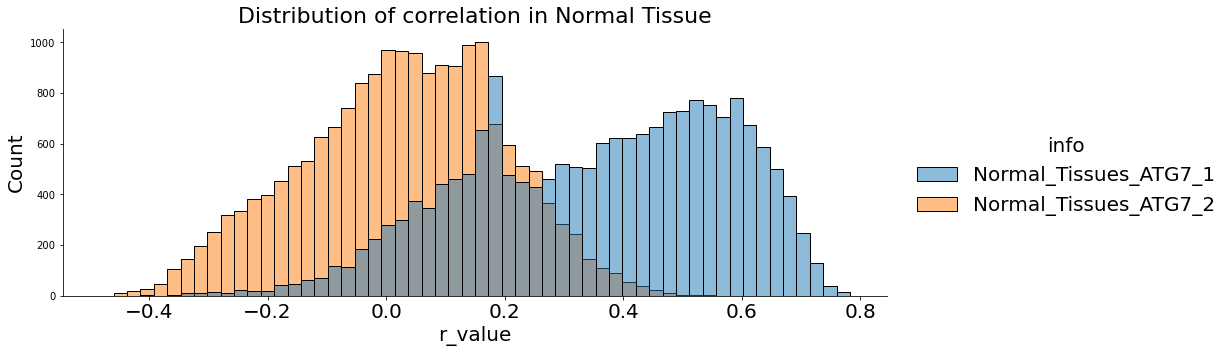

<Figure size 864x576 with 0 Axes>

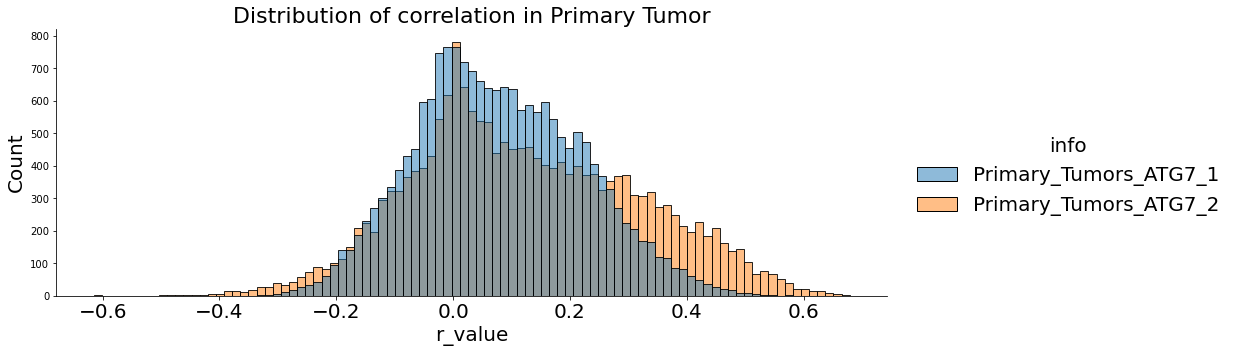

<Figure size 864x576 with 0 Axes>

In [10]:
#Merge ATG7(1) and ATG7(2)
data = [
        [all_corr_negpos_merged[0], all_corr_negpos_merged[1], 'Normal Tissue'],
        [all_corr_negpos_merged[2], all_corr_negpos_merged[3], 'Primary Tumor']
        ]

all_corr_isoforms_merged = []
for dfs in data:
  print('shape normal', dfs[0].shape)
  print('shape primary', dfs[1].shape)

  df_merged = pandas.concat([dfs[0], dfs[1]], axis=0)
  df_merged = df_merged.reset_index(drop = True)
  print('shape after merge', df_merged.shape)
  all_corr_isoforms_merged.append(df_merged)
  print()

#Distribution of correlation
data = [
        [all_corr_isoforms_merged[0], 'Normal Tissue'],
        [all_corr_isoforms_merged[1], 'Primary Tumor']
        ]

for dfs in data:
  seaborn.displot(dfs[0], x="r_value", hue='info', aspect = 2.6)
  label_title = 'Distribution of correlation in ' + dfs[1]
  plt.title(label_title, fontsize = 22)
  plt.show()
  plt.clf()
  print()

In [11]:
# have to select the 1% in extremities to have only the interesting one.
## all_corr_negpos_merged = norm iso1, norm iso2, prim iso1, prim iso2

all_corr_negpos_extremities = []

for df in all_corr_negpos_merged:
  df = df.sort_values(['r_value'], ascending = False)
  df = df.reset_index(drop = True)
  
  lenght = len(df)
  only_1perc = int(lenght*0.01)
  just_head = only_1perc
  just_tail = lenght - only_1perc

  df_head = df.iloc[0:just_head,:]
  df_tail = df.iloc[just_tail:,:]
  df_extremeties = pandas.concat([df_head, df_tail], axis=0)

  inform = df['info'][1]
  extremities_name = 'corr_1%extremities'+ '_' +inform
#   df_extremeties.to_excel(extremities_name+'.xlsx', index=False)

  all_corr_negpos_extremities.append(df_extremeties)
    
all_corr_negpos_extremities[3]

,ensembl_gene_id,hgnc_symbol,r_value,p_value,info
0,ENSG00000115091,ACTR3,0.678909,0,Primary_Tumors_ATG7_2
1,ENSG00000114030,KPNA1,0.670211,0,Primary_Tumors_ATG7_2
2,ENSG00000166847,DCTN5,0.663636,0,Primary_Tumors_ATG7_2
3,ENSG00000037749,MFAP3,0.660469,0,Primary_Tumors_ATG7_2
4,ENSG00000065183,WDR3,0.659841,0,Primary_Tumors_ATG7_2
...,...,...,...,...,...
18833,ENSG00000183260,ABHD16B,-0.473546,0,Primary_Tumors_ATG7_2
18834,ENSG00000205923,CEMP1,-0.476966,0,Primary_Tumors_ATG7_2
18835,ENSG00000099624,ATP5F1D,-0.488744,0,Primary_Tumors_ATG7_2
18836,ENSG00000099821,POLRMT,-0.502876,0,Primary_Tumors_ATG7_2


# IV] Heatmap recap 

In [12]:
all_corr_negpos_ = []

for df in all_corr_negpos_merged:
    df2 = (df.dropna(subset=['ensembl_gene_id'])
             .set_index('ensembl_gene_id').sort_index())
    
    colname = df['info'][0]
    df2 = ( df2.rename(columns = {'r_value' : colname})
            .drop(df2.columns[[0, 2, 3]], axis=1) 
            .fillna(0))
    
    all_corr_negpos_.append(df2)

#merge the df     
df_heatmap_norm = pandas.concat([all_corr_negpos_[0], all_corr_negpos_[1]], axis=1)

df_heatmap_prim = pandas.concat([all_corr_negpos_[2], all_corr_negpos_[3]], axis=1)
df_heatmap_prim


,Primary_Tumors_ATG7_1,Primary_Tumors_ATG7_2
ensembl_gene_id,,
ENSG00000000003,0.017352,0.084175
ENSG00000000005,0.070626,0.048887
ENSG00000000419,-0.072236,0.343707
ENSG00000000457,0.003183,0.428405
ENSG00000000460,-0.049527,0.402187
...,...,...
ENSG00000282301,-0.145664,-0.063949
ENSG00000282419,-0.026760,0.033378
ENSG00000282608,0.348152,0.156396


C:\Users\kja11\anaconda3\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


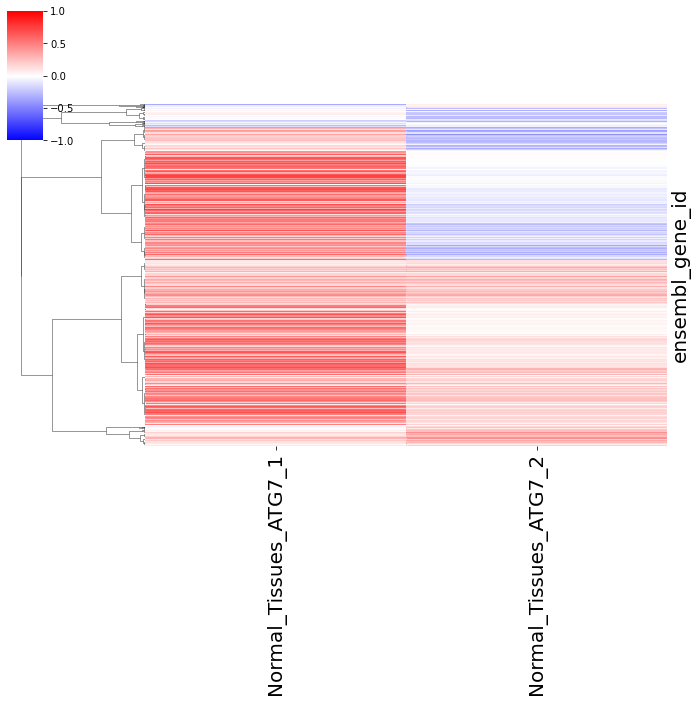

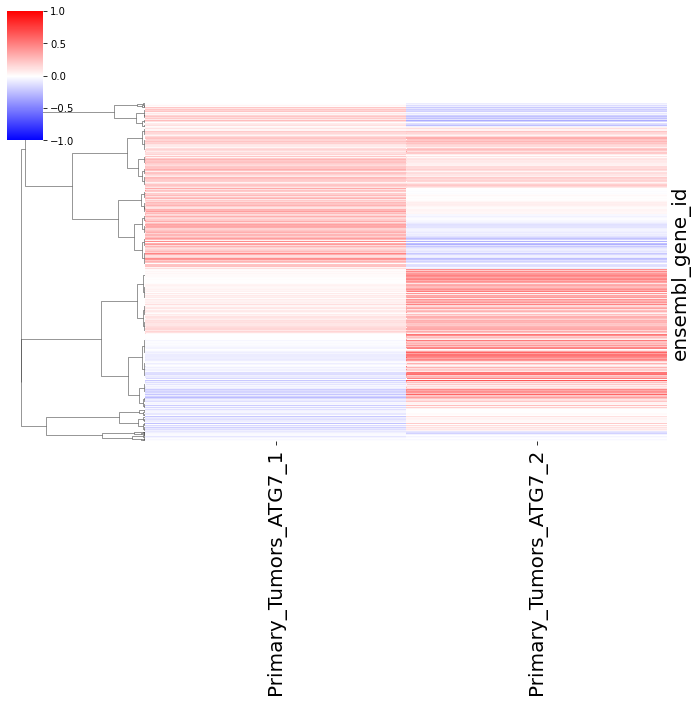

In [13]:
path = 'ATG7/TCGA_GTEX/all_tissues/Correlation/figures_correlation/'

seaborn.clustermap(df_heatmap_norm, vmin=-1, vmax=1, cmap = 'bwr',
                   yticklabels=False, method='complete', metric='cosine', col_cluster=False) 
# plt.title('Correlation of ATG7 expression in normal tissue')
plt.savefig(output_file_directory+path+'heatmap_corr_normal.jpeg', dpi=1200)


seaborn.clustermap(df_heatmap_prim, vmin=-1, vmax=1, cmap = 'bwr',
                   yticklabels=False, method='complete', metric='cosine', col_cluster=False) 
# plt.title('Correlation of ATG7 expression in primary tumor')
plt.savefig(output_file_directory+path+'heatmap_corr_primary.jpeg', dpi=1200)

In [27]:
set1 = set(df_heatmap_norm.index) 
set2 = set(df_heatmap_prim.index) 
intersection = list(set1.intersection(set2))

In [35]:
df_heatmap_norm = df_heatmap_norm[df_heatmap_norm.index.isin(intersection)]
df_heatmap_prim = df_heatmap_prim[df_heatmap_prim.index.isin(intersection)]

In [36]:
df_heatmap_norm_prim = pandas.concat([df_heatmap_norm, df_heatmap_prim], axis=1)
df_heatmap_norm_prim

,Normal_Tissues_ATG7_1,Normal_Tissues_ATG7_2,Primary_Tumors_ATG7_1,Primary_Tumors_ATG7_2
ensembl_gene_id,,,,
ENSG00000000003,0.416096,0.054257,0.017352,0.084175
ENSG00000000005,0.278493,0.150611,0.070626,0.048887
ENSG00000000419,0.579916,0.207171,-0.072236,0.343707
ENSG00000000457,0.592085,0.250049,0.003183,0.428405
ENSG00000000460,0.670107,0.093863,-0.049527,0.402187
...,...,...,...,...
ENSG00000282301,-0.046396,-0.017963,-0.145664,-0.063949
ENSG00000282419,0.180135,0.156991,-0.026760,0.033378
ENSG00000282608,0.348385,0.053411,0.348152,0.156396


C:\Users\kja11\anaconda3\lib\site-packages\seaborn\matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


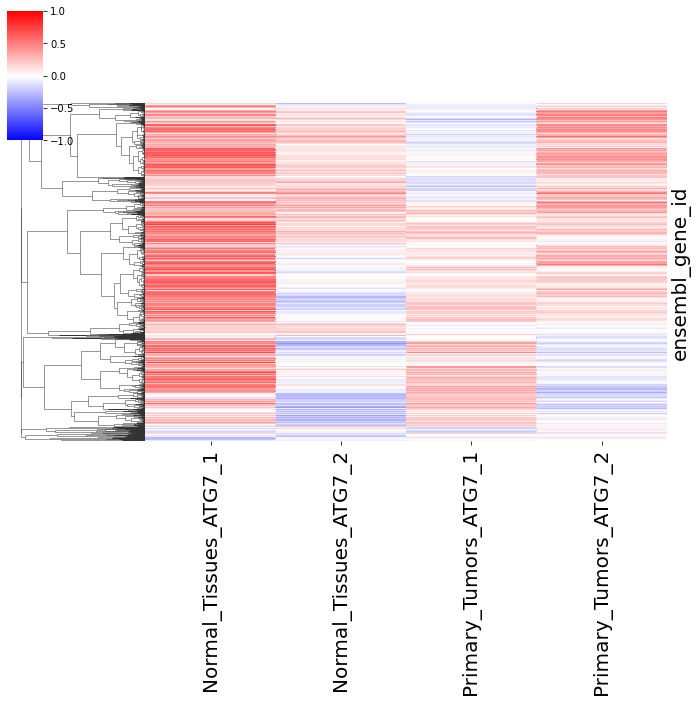

In [37]:
path = 'ATG7/TCGA_GTEX/all_tissues/Correlation/figures_correlation/'

seaborn.clustermap(df_heatmap_norm_prim, vmin=-1, vmax=1, cmap = 'bwr',
                   yticklabels=False, method='complete', metric='cosine', col_cluster=False) 
# plt.title('Correlation of ATG7 expression in normal tissue')
# plt.savefig(output_file_directory+path+'heatmap_corr_normal.jpeg', dpi=1200)


# V] Venn diagrams

In [19]:
all_corr_negpos_extremities[0]

,ensembl_gene_id,hgnc_symbol,r_value,p_value,info
0,ENSG00000230124,ACBD6,0.782894,0,Normal_Tissues_ATG7_1
1,ENSG00000230124,ACBD6,0.782894,0,Normal_Tissues_ATG7_1
2,ENSG00000266173,STRADA,0.782089,0,Normal_Tissues_ATG7_1
3,ENSG00000197548,ATG7,0.780811,0,Normal_Tissues_ATG7_1
4,ENSG00000121775,TMEM39B,0.780761,0,Normal_Tissues_ATG7_1
...,...,...,...,...,...
18726,ENSG00000205678,TECRL,-0.384268,5.12197e-260,Normal_Tissues_ATG7_1
18727,ENSG00000146926,ASB10,-0.404713,7.44451e-291,Normal_Tissues_ATG7_1
18728,ENSG00000186628,FSD2,-0.407449,3.7774e-295,Normal_Tissues_ATG7_1
18729,ENSG00000177354,C10orf71,-0.415614,3.31757e-308,Normal_Tissues_ATG7_1


In [20]:
len(all_corr_negpos_merged)

4

In [21]:
#separate pos and neg correlation
all_corr_positiv_extremities = []
all_corr_negativ_extremities = []

for df in all_corr_negpos_extremities:
    data_pos = df[df['r_value']>0]
    data_neg = df[df['r_value']<0]
    all_corr_positiv_extremities.append(data_pos)
    all_corr_negativ_extremities.append(data_neg)
print(len(all_corr_positiv_extremities))
all_corr_negativ_extremities[0].head()

4


,ensembl_gene_id,hgnc_symbol,r_value,p_value,info
18544,ENSG00000138075,ABCG5,-0.150226,9.41827e-39,Normal_Tissues_ATG7_1
18545,ENSG00000092054,MYH7,-0.15028,8.85497e-39,Normal_Tissues_ATG7_1
18546,ENSG00000109511,ANXA10,-0.150889,4.38908e-39,Normal_Tissues_ATG7_1
18547,ENSG00000196482,ESRRG,-0.151751,1.6206e-39,Normal_Tissues_ATG7_1
18548,ENSG00000204613,TRIM10,-0.151846,1.45074e-39,Normal_Tissues_ATG7_1


## 1) Venn diagrams of correlation of all the genes

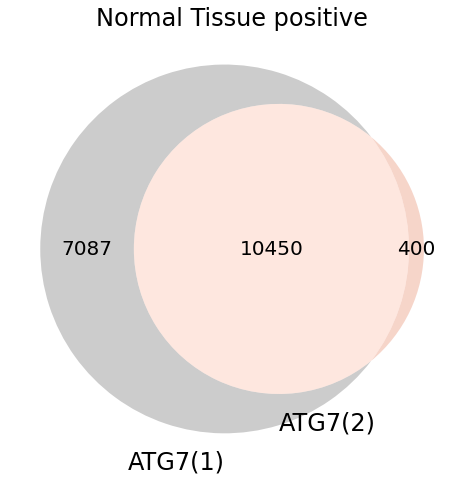

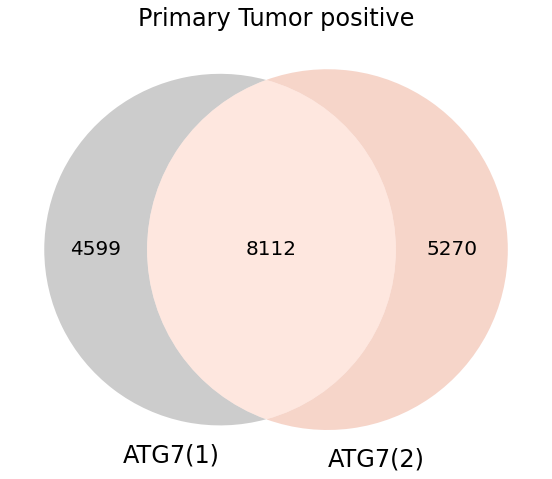

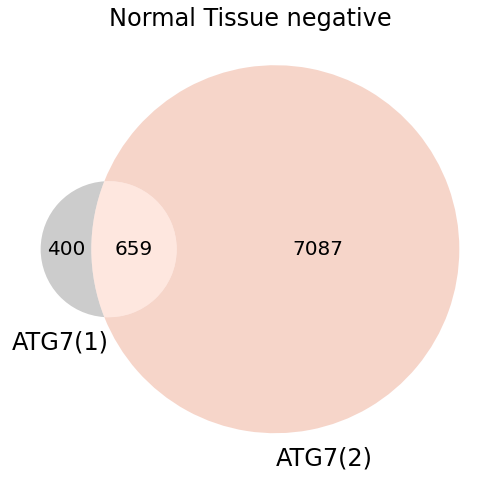

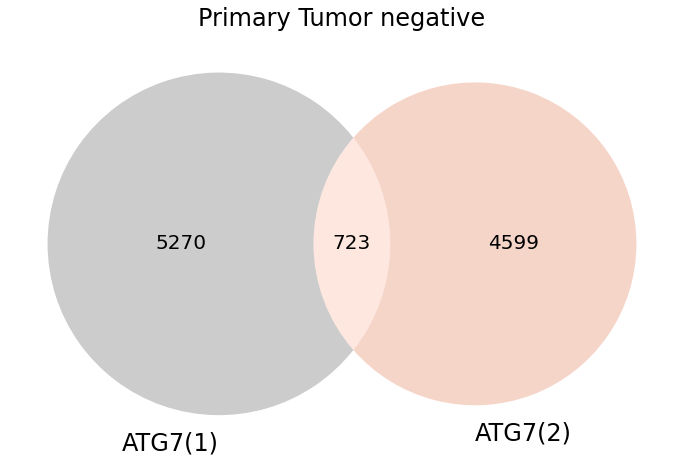

<Figure size 864x576 with 0 Axes>

In [24]:
#VENN DIAGRAMS ATG7(1) vs ATG7(2) FOR the 100% of the genes

data_pos =  [
         [all_positiv_corr_spearman[0], all_positiv_corr_spearman[1], 'Normal Tissue', 'positive'], 
         [all_positiv_corr_spearman[2], all_positiv_corr_spearman[3], 'Primary Tumor', 'positive']
         ]

data_neg =  [
         [all_negativ_corr_spearman[0], all_negativ_corr_spearman[1], 'Normal Tissue', 'negative'], 
         [all_negativ_corr_spearman[2], all_negativ_corr_spearman[3], 'Primary Tumor', 'negative']
         ]

data = data_pos + data_neg

list_only1 = []
list_only2 = []

for dfs in data:
  set1 = set(dfs[0]['ensembl_gene_id'])
  set2 = set(dfs[1]['ensembl_gene_id'])
  subset = (set1, set2)

  #just to save some results in list
  with_only1 = set2.symmetric_difference(set1) & set1
  list_only1.append(with_only1)

  with_only2 = set2.symmetric_difference(set1) & set2
  list_only2.append(with_only2)

  #Venn Diagram
  venn2(subset, set_labels=('ATG7(1)', 'ATG7(2)'), set_colors=('grey', 'darksalmon'))
  label_title = dfs[2] + ' ' + dfs[3]
  plt.title(label_title)
  path = 'ATG7/TCGA_GTEX/all_tissues/Correlation/venn_diagram/all_correlation/'
  plt.savefig(output_file_directory+path+label_title+'.svg')
    
  plt.show()
  plt.clf()
  print()




## 2) Venn diagrams of the 1% the most correlated genes with the two isoforms for each tissue 

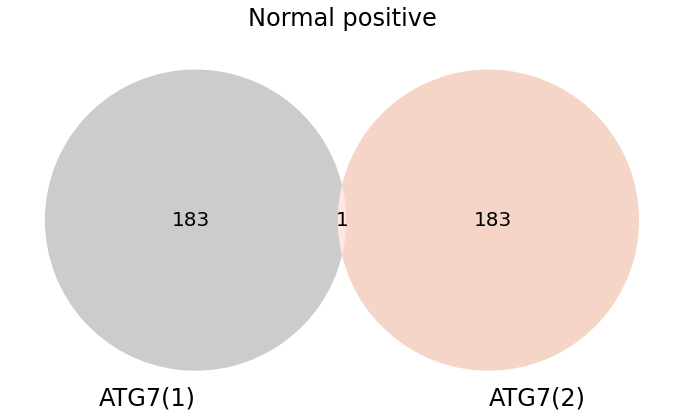

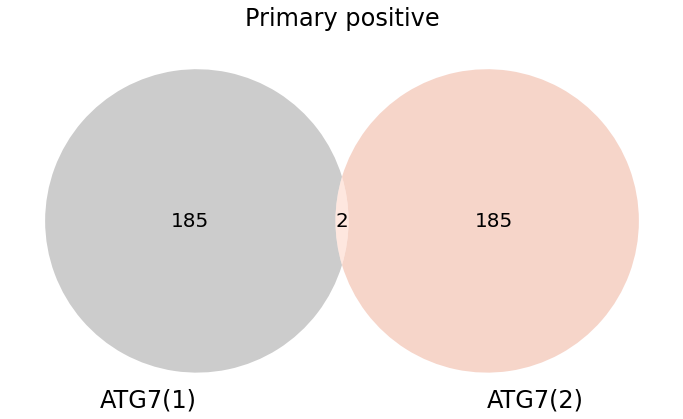

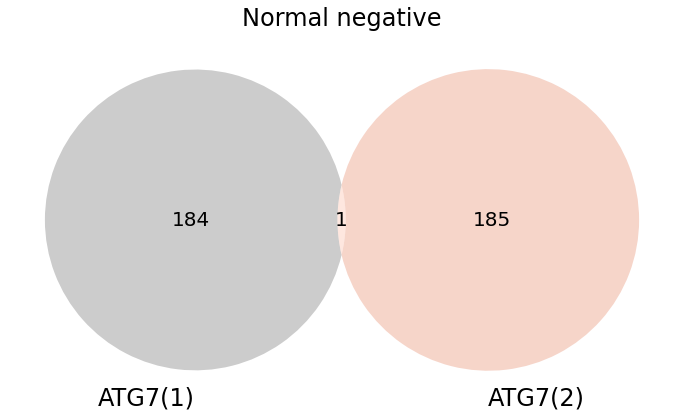

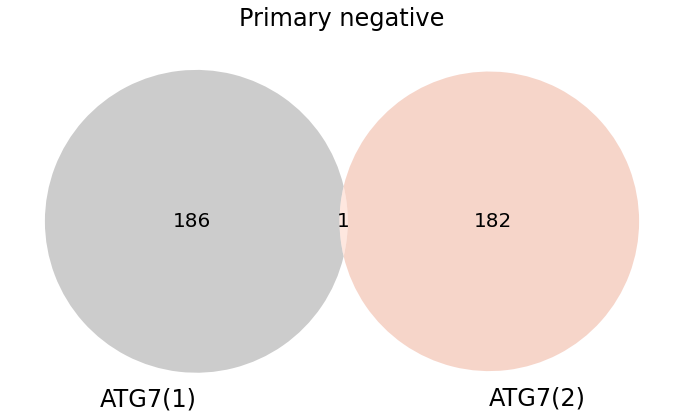

<Figure size 864x576 with 0 Axes>

In [25]:
#VENN DIAGRAMS ATG7(1)vs ATG7(2) FOR the 1% of the genes the most correlated
data_pos =  [
         [all_corr_positiv_extremities[0], all_corr_positiv_extremities[1], 'Normal', 'positive'], 
         [all_corr_positiv_extremities[2], all_corr_positiv_extremities[3], 'Primary', 'positive']
         ]

data_neg =  [
         [all_corr_negativ_extremities[0], all_corr_negativ_extremities[1], 'Normal', 'negative'], 
         [all_corr_negativ_extremities[2], all_corr_negativ_extremities[3], 'Primary', 'negative']
         ]

data = data_pos + data_neg

for dfs in data:
    set1 = set(dfs[0]['hgnc_symbol'])
    set2 = set(dfs[1]['hgnc_symbol'])
    subset = (set1, set2)

    #save results in list
    with_only1 = list(set2.symmetric_difference(set1) & set1)
    with_only2 = list(set2.symmetric_difference(set1) & set2)
    intersection = set1.intersection(set2)

    #create a dictionnary
    d = dict(Only_ATG7_1 = with_only1, Only_ATG7_2 = with_only2, Intersection= intersection)

    #Convert to dataframe
    df_only_and_intersection = pandas.DataFrame.from_dict(d, orient='index')
    name_file = 'only_and_intersection_isos_'+dfs[2]+'_'+dfs[3]
       
    #Transpose to have a better table and save
    df_only_and_intersection = df_only_and_intersection.transpose()
    df_only_and_intersection['info'] = dfs[2]+dfs[3]
    
    path = 'ATG7/table_correlation_enrichr/all_tissue_ATG7/corr_extremities/'
#     df_only_and_intersection.to_excel(output_file_directory+path+name_file+'.xlsx', index=False)
    
    #Venn Diagram
    venn2(subset, set_labels=('ATG7(1)', 'ATG7(2)'), set_colors=('grey', 'darksalmon'))
    label_title = dfs[2] + ' ' + dfs[3]
    plt.title(label_title)
    path = 'ATG7/TCGA_GTEX/all_tissues/Correlation/venn_diagram/1perc_correlation/'
    plt.savefig(output_file_directory+path+label_title+'.svg')
    
    plt.show()
    plt.clf()

    print()

In [ ]:
print(len(all_corr_negativ_extremities), 'iso1_norm, iso2_norm, iso1_prim, iso2_prim')

## 3) Venn diagrams of the 1% the most correlated genes for each isoform in normal and primary tissues

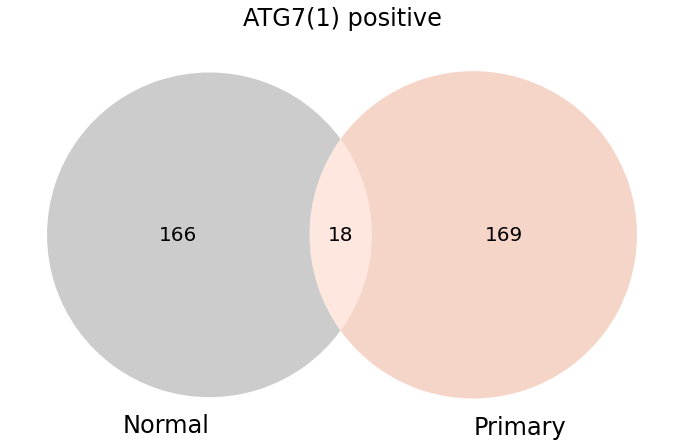

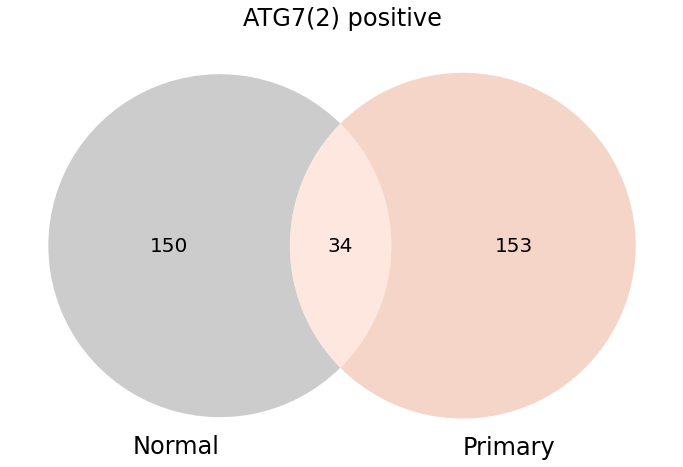

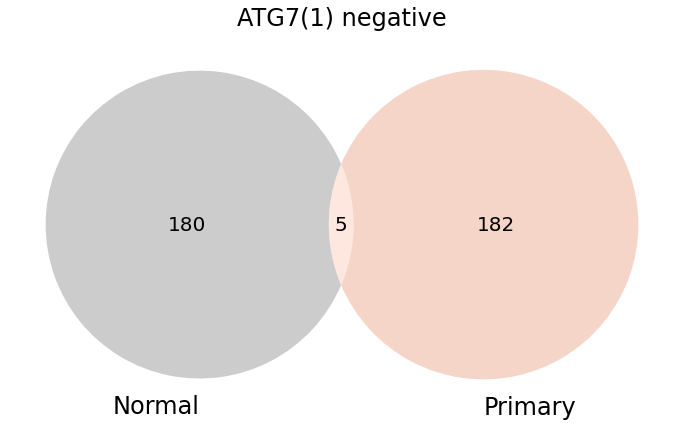

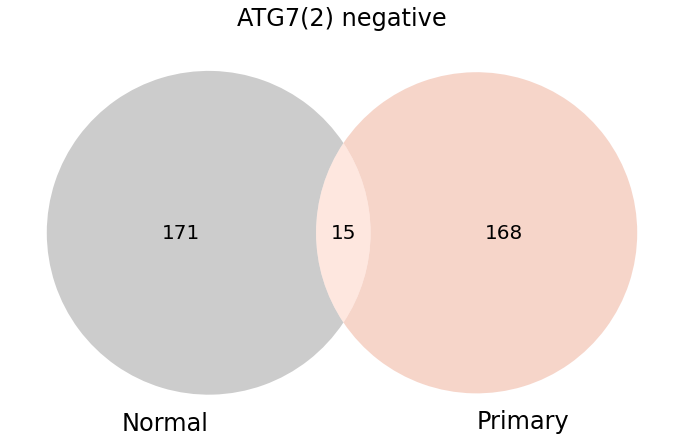

<Figure size 864x576 with 0 Axes>

In [26]:
#VENN DIAGRAMS FOR NORM vs PRIM for the 1% of the genes the most correlated
data_pos =  [
         [all_corr_positiv_extremities[0], all_corr_positiv_extremities[2], 'ATG7(1)', 'positive'], 
         [all_corr_positiv_extremities[1], all_corr_positiv_extremities[3], 'ATG7(2)', 'positive']
         ]

data_neg =  [
         [all_corr_negativ_extremities[0], all_corr_negativ_extremities[2], 'ATG7(1)', 'negative'], 
         [all_corr_negativ_extremities[1], all_corr_negativ_extremities[3], 'ATG7(2)', 'negative']
         ]

data = data_pos + data_neg

for dfs in data:
    set1 = set(dfs[0]['hgnc_symbol'])
    set2 = set(dfs[1]['hgnc_symbol'])
    subset = (set1, set2)

    #save results in list
    with_normal = list(set2.symmetric_difference(set1) & set1)
    with_primary = list(set2.symmetric_difference(set1) & set2)
    intersection = set1.intersection(set2)

    #create a dictionnary
    d = dict(Only_normal = with_normal, Only_primary = with_primary, Intersection= intersection)

    #Convert to dataframe
    df_only_and_intersection = pandas.DataFrame.from_dict(d, orient='index')
    name_file = 'only_and_intersection_isos_'+dfs[2]+'_'+dfs[3]
       
    #Transpose to have a better table and save
    df_only_and_intersection = df_only_and_intersection.transpose()
    df_only_and_intersection['info'] = dfs[2]+dfs[3]
    
    path = 'ATG7/table_correlation_enrichr/all_tissue_ATG7/corr_extremities/'
#     df_only_and_intersection.to_excel(output_file_directory+path+name_file+'.xlsx', index=False)
    
    #Venn Diagram
    venn2(subset, set_labels=('Normal', 'Primary'), set_colors=('grey', 'darksalmon'))
    label_title = dfs[2] + ' ' + dfs[3]
    plt.title(label_title)
    path = 'ATG7/TCGA_GTEX/all_tissues/Correlation/venn_diagram/1perc_correlation/'
    plt.savefig(output_file_directory+path+label_title+'.svg') 

    plt.show()
    plt.clf()

    print()